In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext line_profiler

import tensorflow as tf
slim = tf.contrib.slim
tf.logging.set_verbosity(tf.logging.INFO)
sess_config = tf.ConfigProto()
#config.gpu_options.allow_growth=True
#config.gpu_options.per_process_gpu_memory_fraction=0.45

import sys
import os

ADE20K_DATA = '/gpfs01/bethge/data/ADE20K_2016_07_26'
COCO_DATA = '/gpfs01/bethge/share/mscoco/COCO'
PASCAL_VOC_DATA = '/gpfs01/bethge/data/PascalVOC'
MASK_RCNN_MODEL_PATH = 'Mask_RCNN/'
SLIM_MODELS_PATH = 'slim/'
TRANSFORMER_MODELS_PATH = 'transformer/'
SIAMESE_MASK_RCNN_PATH = '/gpfs01/bethge/home/cmichaelis/projects/2018-03_Siamese_Mask_RCNN/siamese-mask-rcnn/'

if MASK_RCNN_MODEL_PATH not in sys.path:
    sys.path.append(MASK_RCNN_MODEL_PATH)
if SIAMESE_MASK_RCNN_PATH not in sys.path:
    sys.path.append(SIAMESE_MASK_RCNN_PATH)
    
from samples.coco import coco
from samples.ade20k import ade20k
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
    
if SLIM_MODELS_PATH not in sys.path:
    sys.path.append(SLIM_MODELS_PATH)
if TRANSFORMER_MODELS_PATH not in sys.path:
    sys.path.append(TRANSFORMER_MODELS_PATH)
    
import utils as siamese_utils
import model as siamese_model
import siamese_mrcnn_models as model_zoo
    
import time
import random
import numpy as np
import skimage.io
import imgaug
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 6.0)

from spatial_transformer import transformer

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

Instructions for updating:
Use the retry module or similar alternatives.


Using TensorFlow backend.


In [2]:
nopascal_classes = [8,10,11,12,13,14,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,60,62,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80]

In [3]:
pascal_classes = np.array(range(1,81))[np.array([i not in nopascal_classes for i in range(1,81)])]

In [4]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1 #6 #12
    LEARNING_RATE = 0.001
    NUM_CLASSES = 80 + 1
    TARGET_MAX_DIM = 96
    TARGET_MIN_DIM = 75
    IMAGE_MIN_DIM = 400
    IMAGE_MAX_DIM = 512
    #IMAGE_RESIZE_MODE = 'none'
    TARGET_SHAPE = np.array([TARGET_MAX_DIM, TARGET_MAX_DIM, 3])
    TARGET_PADDING = True
    MAX_TARGET_INSTANCES = 10
    # Reduce model size for prototyping
    BACKBONE = 'resnet50'
    FPN_FEATUREMAPS = 128
    RPN_ANCHOR_STRIDE = 2
    RPN_TRAIN_ANCHORS_PER_IMAGE = 64
    POST_NMS_ROIS_TRAINING = 250
    POST_NMS_ROIS_INFERENCE = 250
    TRAIN_ROIS_PER_IMAGE = 50
    DETECTION_MAX_INSTANCES = 15
    DETECTION_NMS_THRESHOLD = 0.5
    MAX_GT_INSTANCES = 15
    ACTIVE_CLASSES = np.array(range(1,81))

config = InferenceConfig()
config.display()


Configurations:
ACTIVE_CLASSES                 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80]
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        15
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
FPN_FEATUREMAPS                128
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  400
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEA

In [5]:
# Load COCO/val dataset
val_dataset = siamese_utils.IndexedCocoDataset()
val_dataset.load_coco(COCO_DATA, "val", year=2017)
val_dataset.prepare()
val_dataset.build_indices()

loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


### Visualization

In [6]:
model_name = 'coco20180529T1829/mask_rcnn_coco_0369.h5'
trainables = "(res2.*)|(bn2.*)|(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)"

In [7]:
model = model_zoo.FancySiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.set_trainable(trainables, verbose=0)
# Load weights
model.load_weights('/gpfs01/bethge/home/cmichaelis/projects/2018-03_Siamese_Mask_RCNN/logs/' + model_name, by_name=True)

Re-starting from epoch 369


In [8]:
targets = []
images = []
rois = []
masks = []
class_ids = []
scores = []

In [1951]:
IMAGE_DIR = '/gpfs01/bethge/home/cmichaelis/datasets/COCO/val2017/'

# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
coco_image_ids = [val_dataset.image_info[id]["id"] for id in val_dataset.image_ids]

p = 1
while p < 2:

    # Load target
    category = 3
    random_image_id = np.random.choice(val_dataset.category_image_index[category])
    # random_image_id = 4005
    image = val_dataset.load_image(random_image_id)

    if np.abs(image.shape[0] / image.shape[1] - (3 / 2)) > 0.01:
        continue

    # target_image, _, target_class_ids, target_boxes, _ = \
    #     modellib.load_image_gt(val_dataset, config, random_image_id, augmentation=False,
    #                   use_mini_mask=config.USE_MINI_MASK)

    # box_ind = np.random.choice(np.where(target_class_ids == category)[0])   
    # tb = target_boxes[box_ind,:]
    # target = target_image[tb[0]:tb[2],tb[1]:tb[3],:]
#     target1, window, scale, padding1, crop = siamese_utils.get_one_target(category, val_dataset, config, return_all=True)

    # Run detection
    results1 = model.detect([target1], [image], verbose=1)
    r1 = results1[0]
    cropped_target1 = siamese_utils.crop_target(target1, padding1)
    rois1 = r1['rois']
    masks1 = r1['masks']
    class_ids1 = r1['class_ids']
    scores1 = r1['scores']
    
#     target2, window, scale, padding2, crop = siamese_utils.get_one_target(category, val_dataset, config, return_all=True)

    # Run detection
    results2 = model.detect([target2], [image], verbose=1)
    r2 = results2[0]
    cropped_target2 = siamese_utils.crop_target(target2, padding2)
    rois2 = r2['rois']
    masks2 = r2['masks']
    class_ids2 = r2['class_ids']
    scores2 = r2['scores']

    cropped_target = siamese_utils.crop_target(target, padding)
    # siamese_utils.display_siamese_instances2(cropped_target, image, r['rois'], r['masks'], r['class_ids'], r['scores'])

    targets.append(cropped_target)
    images.append(image)
    rois.append(r['rois'])
    masks.append(r['masks'])
    class_ids.append(r['class_ids'])
    scores.append(r['scores'])
    
    p = p + 1

Processing 1 images
image                    shape: (640, 427, 3)         min:    0.00000  max:  255.00000  uint8
target                   shape: (1, 96, 96, 3)        min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
molded_targets           shape: (1, 96, 96, 3)        min:    0.00000  max:  253.00000  uint8
anchors                  shape: (1, 16368, 4)         min:   -0.70849  max:    1.45800  float32
Processing 1 images
image                    shape: (640, 427, 3)         min:    0.00000  max:  255.00000  uint8
target                   shape: (1, 96, 96, 3)        min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
molded_targets           shape: (1, 96, 96, 3)        min:    0.00000  max:  244.00000  uint8
anchors                  shape: (1, 16368, 4)         min:   -0.70849  max:    1.45800  float32


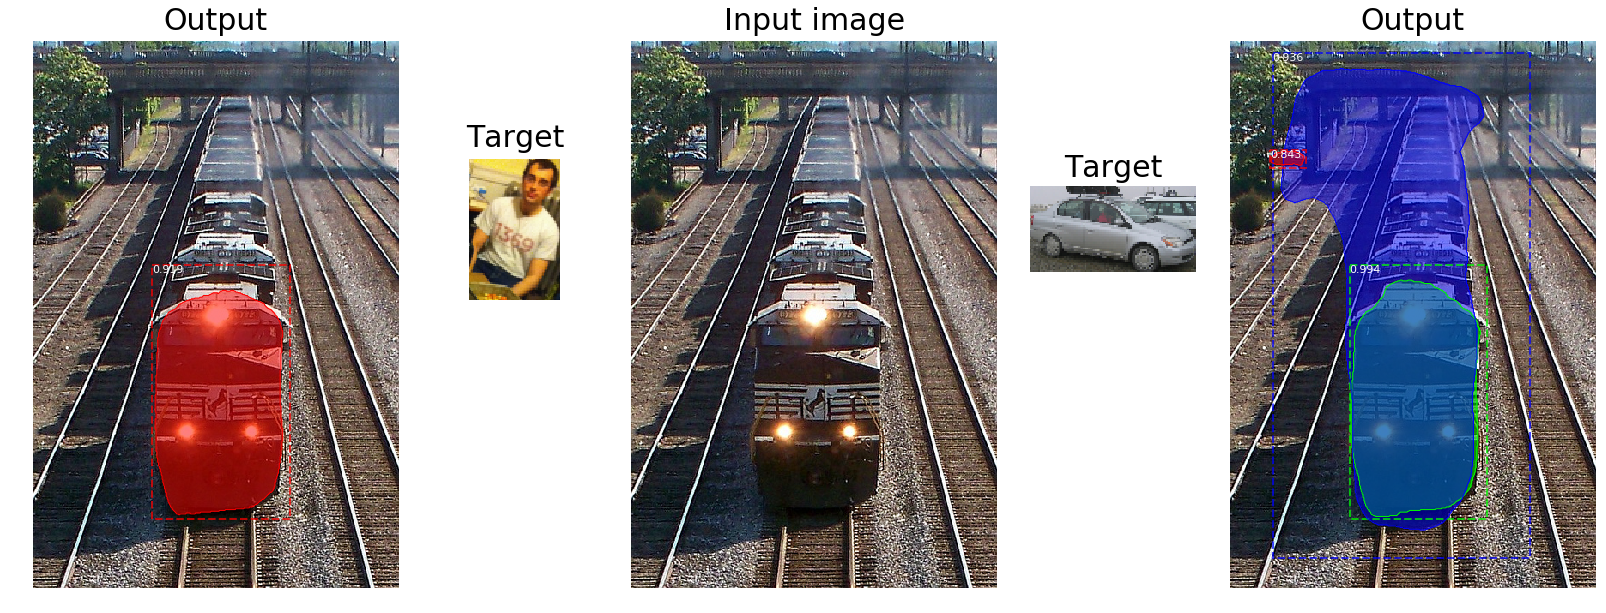

In [1952]:
siamese_utils.display_siamese_instances_teaser([cropped_target1, cropped_target2],
                                               [image]*2,
                                               [rois1, rois2],
                                               [masks1, masks2],
                                               [class_ids1, class_ids2],
                                               [scores1, scores2],
                                               figsize=(8 + 2 + 8 + 2 + 8, 12), fontsize=30)

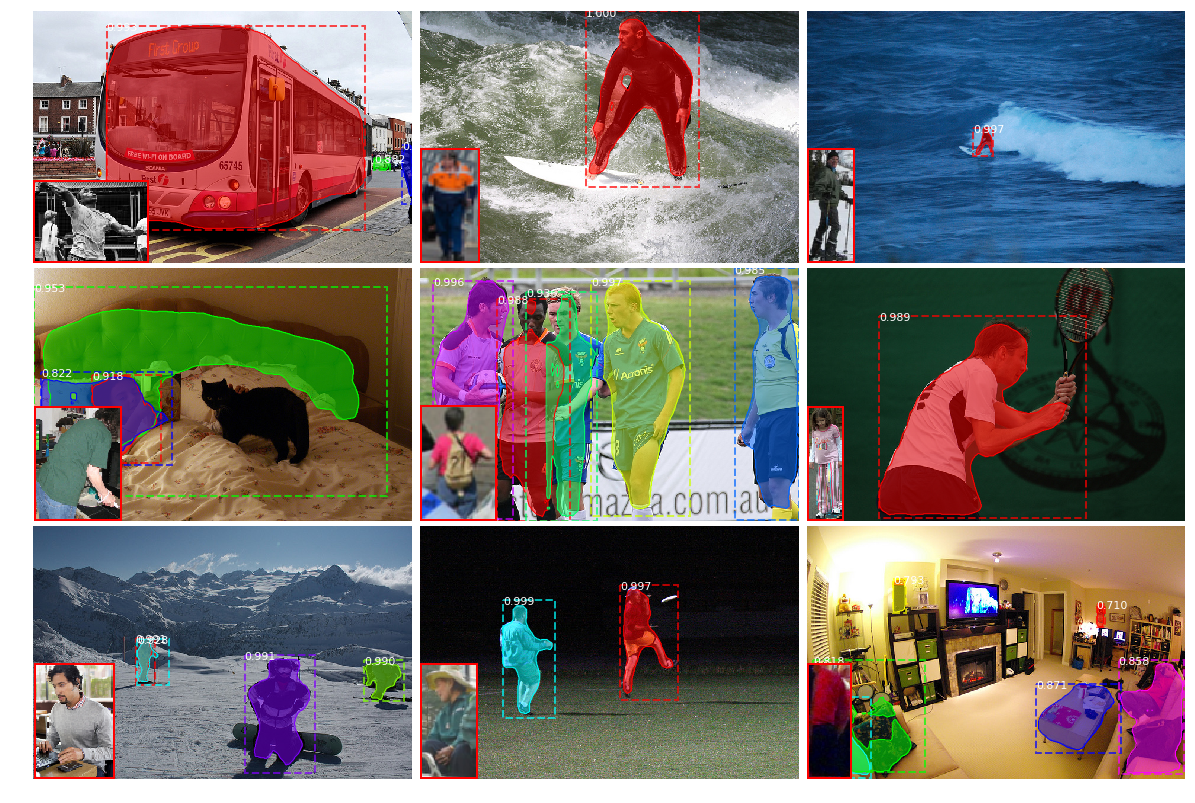

In [27]:
siamese_utils.display_siamese_instances2(targets, images, rois, masks, class_ids, scores, figsize=(16, 16 * 2 / 3),
                                         target_shift=2)

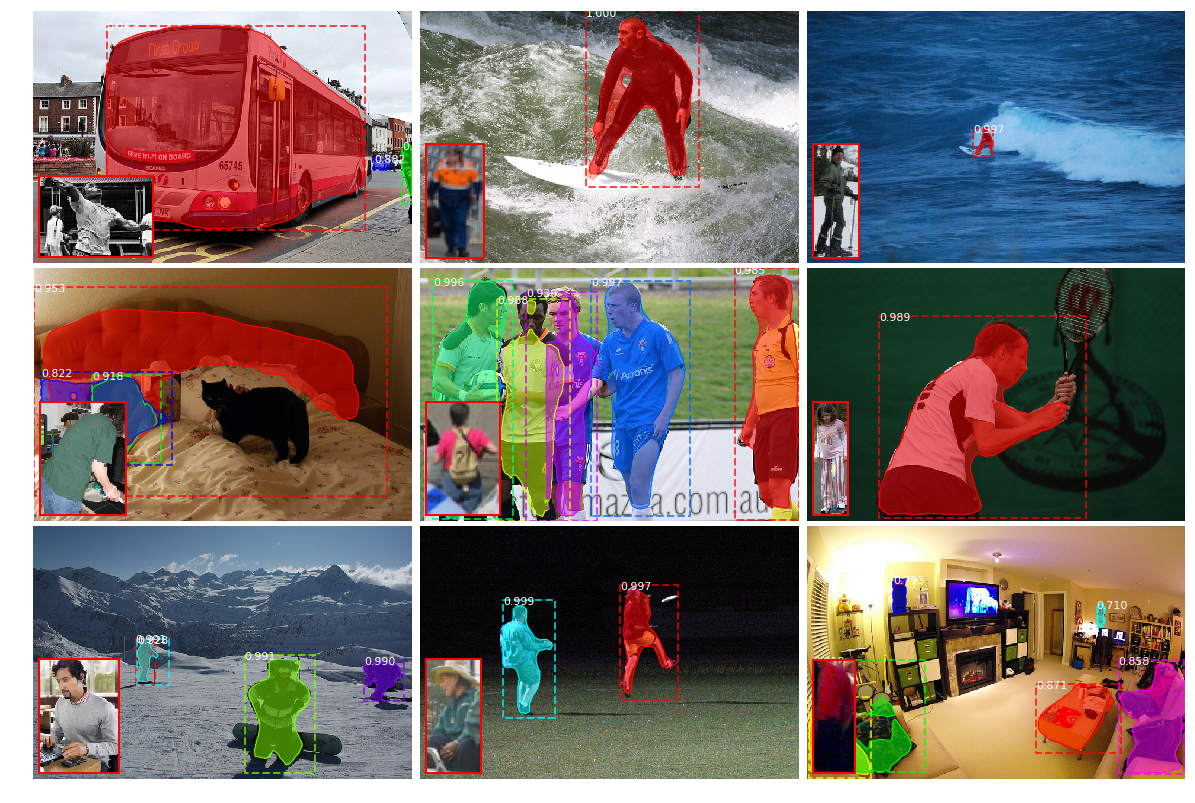

In [28]:
siamese_utils.display_siamese_instances2(targets, images, rois, masks, class_ids, scores, figsize=(16, 16 * 2 / 3),
                                         target_shift=10)

In [162]:
type(target)

numpy.ndarray

In [125]:
4872, 4005

(4872, 4005)

In [52]:
random_image_id

4005

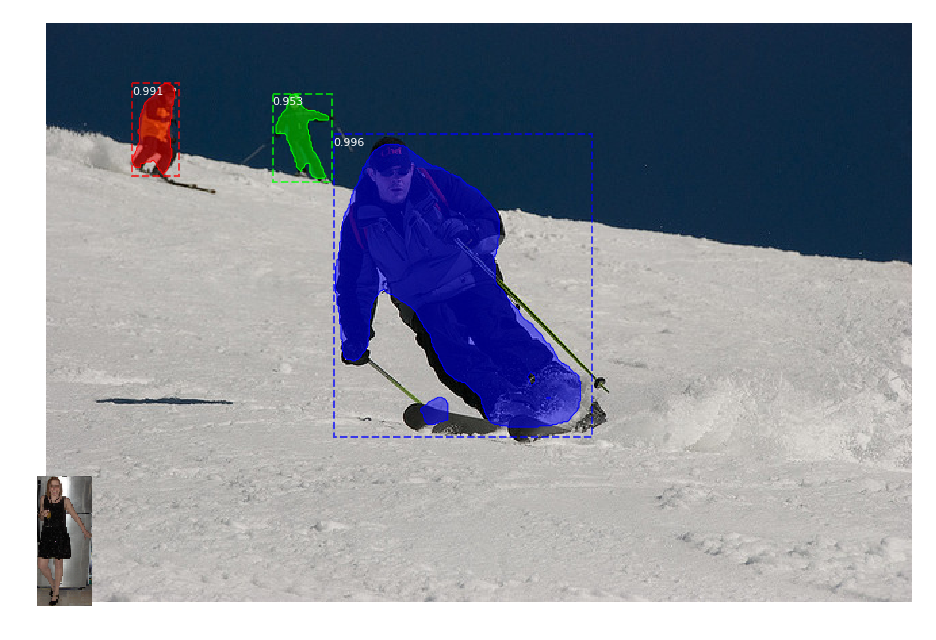

In [120]:
siamese_utils.display_siamese_instances2(target[:, 28:-28,:], image, r['rois'], r['masks'], r['class_ids'], r['scores'])

In [100]:
target.shape

(96, 96, 3)

In [135]:
padding

[(21, 21), (0, 0), (0, 0)]

In [141]:
target[slice(21, 96 - 21), slice(0, 96),:]

(54, 96, 3)

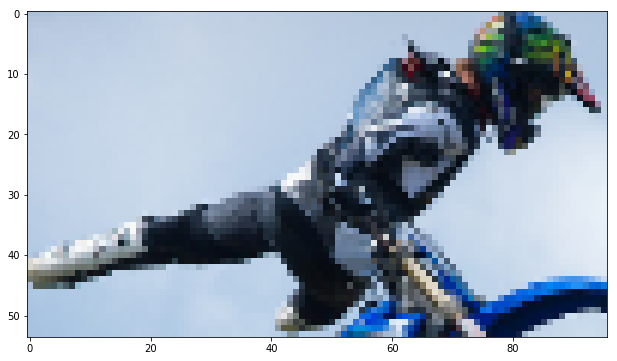

In [142]:
plt.imshow(target[slice(21, 96 - 21), slice(0, 96),:])